# VAE on the real BACMMAN dataset

In [1]:
# DRIVE
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/BACMMAN_DISTNET/')

!pip install git+https://github.com/jeanollion/dataset_iterator.git
!pip install git+https://github.com/jeanollion/distnet.git
import tensorflow as tf
import h5py
import numpy as np
import matplotlib.pyplot as plt

from uad.decision.reconstruction import is_anormal, decision_function, binarize_set
from uad.diagnostic.visualisation import plot_tSNE
from uad.diagnostic.metrics import compute_ROC, compute_AUC, plot_ROC

# copy data locallly
dataset_dir = f"/content/drive/My Drive/BACMMAN_DISTNET/data/BACMMAN/"
!cp "/content/drive/My Drive/BACMMAN_DISTNET/data/BACMMAN/train_val_eval.h5" "/home/train_val_eval.h5"
dataset_path = "/home/train_val_eval.h5"
print(dataset_path)

!nvidia-smi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Cloning https://github.com/jeanollion/dataset_iterator.git to /tmp/pip-req-build-p_9bvp8v
  Running command git clone -q https://github.com/jeanollion/dataset_iterator.git /tmp/pip-req-build-p_9bvp8v
  Created wheel for dataset-iterator: filename=dataset_iterator-0.0.1-cp36-none-any.whl size=35945 sha256=6a56e5eca7acef4d1bc69a0f92d9836bb36eba1778af9ddae48e70678130217f
  Stored in directory: /tmp/pip-ephem-wheel-cache-yx3n32yo/wheels/e1/b1/4a/efb8888afaa53e058db8520c203e13af93ca10b2a8d42ab098
Successfully built dataset-iterator
  Cloning https://github.com/jeanollion/distnet.git to /tmp/pip-req-build-0jamvtkr
  Running command git clone -q https://github.com/jeanollion/distnet.git /tmp/pip-req-build-0jamvtkr
  Created wheel for distnet: filename=distnet-0.0.1-cp36-none-any.whl size=51344 sha256=ef81c1d43fa4059787409d99df785b1706d7c84de06ecd3c6111c4d792faae78

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


/home/train_val_eval.h5
Mon Aug  3 08:11:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                

## Load datasets

In [2]:
# concatenate evaluation sets (norm only and anormal only) into a single h5
# file --> more convenient to load them into a single iterator after

from dataset_iterator import MultiChannelIterator, PreProcessingImageGenerator

eval_set_path = "/home/eval_set.h5"

# evaluation set, nominal and anormal classes ()
x_test_norm = MultiChannelIterator(dataset=dataset_path, 
                                channel_keywords=["/raw"],
                                group_keyword = "eval_norm",
                                input_channels=[0],
                                output_channels=[0], 
                                batch_size=64
                                )

x_test_anorm = MultiChannelIterator(dataset=dataset_path, 
                                channel_keywords=["/raw"],
                                group_keyword = "eval_anom",
                                input_channels=[0],
                                output_channels=[0], 
                                batch_size=64
                                )


def get_images(iterator):
    images = []
    for i in range(len(iterator)):
        bx, by = iterator[i]
        for im in bx:
            images.append(im)
    return np.array(images)

# get images
nominal_images = get_images(x_test_norm)
n_nominal = nominal_images.shape[0]
print(f"{n_nominal} nominal images")
anormal_images = get_images(x_test_anorm)
n_anormal = anormal_images.shape[0]
print(f"{n_anormal} anormal images")

with h5py.File(eval_set_path, 'w') as out_file:
    out_file.create_dataset("eval/0/raw", data=get_images(x_test_norm))
    out_file.create_dataset("eval/0/labels", data=np.zeros(n_nominal))
    out_file.create_dataset("eval/1/raw", data=get_images(x_test_anorm))
    out_file.create_dataset("eval/1/labels", data=np.array([1 for i in range(n_anormal)]))

851 nominal images
1011 anormal images


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from distnet.utils.pre_processing import random_scaling
from dataset_iterator.helpers import get_min_and_max

corruption_function = lambda im: im + np.random.uniform(0, 0, im.shape) 

def global_contrast_normalization(im, s=1, lmda=1, epsilon=1e-9):
    mu = np.mean(im)
    im = im - mu
    contrast = np.sqrt(lmda + np.mean(im**2))
    im = s * im / max(contrast, epsilon)
    return im

data_gen_train = ImageDataGenerator(
                                horizontal_flip=True,
                                # vertical_flip=True,
                                # height_shift_range=0.2,
                                # channel_shift_range=0.2,
                                fill_mode="nearest",)

def corruption_mm_scaling(batch_by_channel):
    minpix, maxpix = np.amin(batch_by_channel[0]), np.amax(batch_by_channel[0])
    batch_by_channel[0] = (batch_by_channel[0] - minpix) / (maxpix - minpix)
    batch_by_channel[1] = np.copy(batch_by_channel[0]) # creating channel 1
    batch_by_channel[0] = corruption_function(batch_by_channel[0])  # corruption on channel 0 only


def mm_scaling(batch_by_channel):
    minpix, maxpix = np.amin(batch_by_channel[0]), np.amax(batch_by_channel[0])
    batch_by_channel[0] = (batch_by_channel[0] - minpix) / (maxpix - minpix)

In [4]:
# train set, interest class only ([augmentation + corruption, augmentation without corruption])
x_train = MultiChannelIterator(dataset=dataset_path, 
                                channel_keywords=["/raw", None],
                                group_keyword = "train", 
                                input_channels=[0],
                                output_channels=[1], 
                                image_data_generators=[data_gen_train, None],
                                channels_postprocessing_function=corruption_mm_scaling,
                                batch_size=100
                                )

# validation set, interest class only ([augmentation without corruption])
x_val = MultiChannelIterator(dataset=dataset_path, 
                                channel_keywords=["/raw"],
                                group_keyword = "val",
                                input_channels=[0],
                                output_channels=[0], 
                                channels_postprocessing_function=mm_scaling,
                                batch_size=100
                                )

# evaluation set, nominal and anormal classes ()
x_test = MultiChannelIterator(dataset=eval_set_path, 
                                channel_keywords=["/raw", "/labels"],
                                group_keyword = ["eval/{}/".format(lab) for lab in range(2)],
                                input_channels=[0],
                                output_channels=[0, 1],
                                channels_postprocessing_function=mm_scaling, 
                                batch_size=64
                                )

print(f"Number of batches {len(x_train)} of size {len(x_train[0][0])}")

Number of batches 100 of size 100


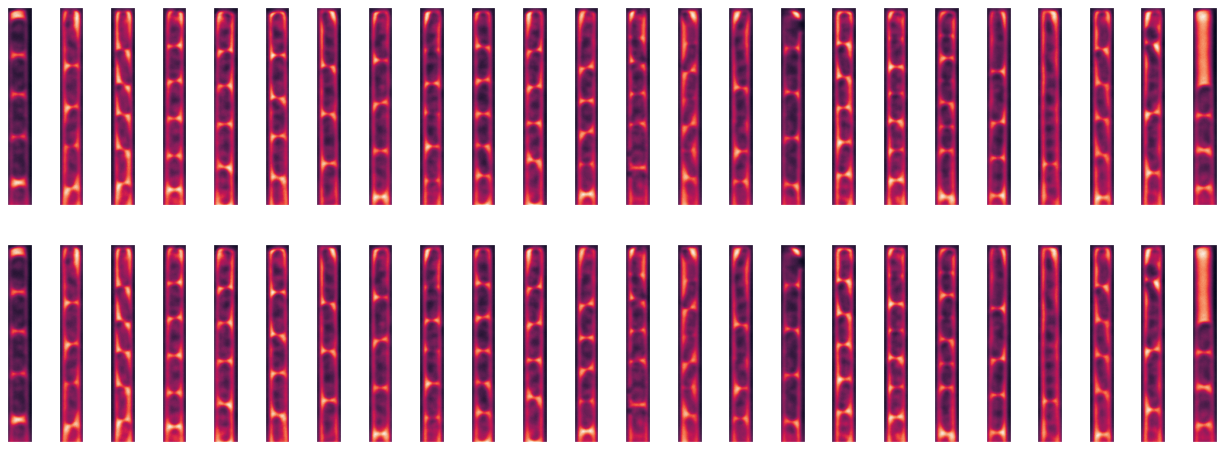

In [5]:
def plot_small_batches(n_batches=6, n=4, labx=None, laby=None):
    fig, axes = plt.subplots(2, n_batches * n, figsize=(22, 8), sharex="all", sharey="all")
    for batch in range(n_batches):
        bx, by = x_train[batch]
        for i in range(n):
            axes[0][i + batch * n].imshow(bx[i].squeeze(-1))
            axes[1][i + batch * n].imshow(by[i].squeeze(-1))
            axes[0][i + batch * n].get_xaxis().set_visible(False)
            axes[1][i + batch * n].get_yaxis().set_visible(False)
            axes[0][i + batch * n].get_xaxis().set_ticks([])
            axes[1][i + batch * n].get_yaxis().set_ticks([])

plot_small_batches()

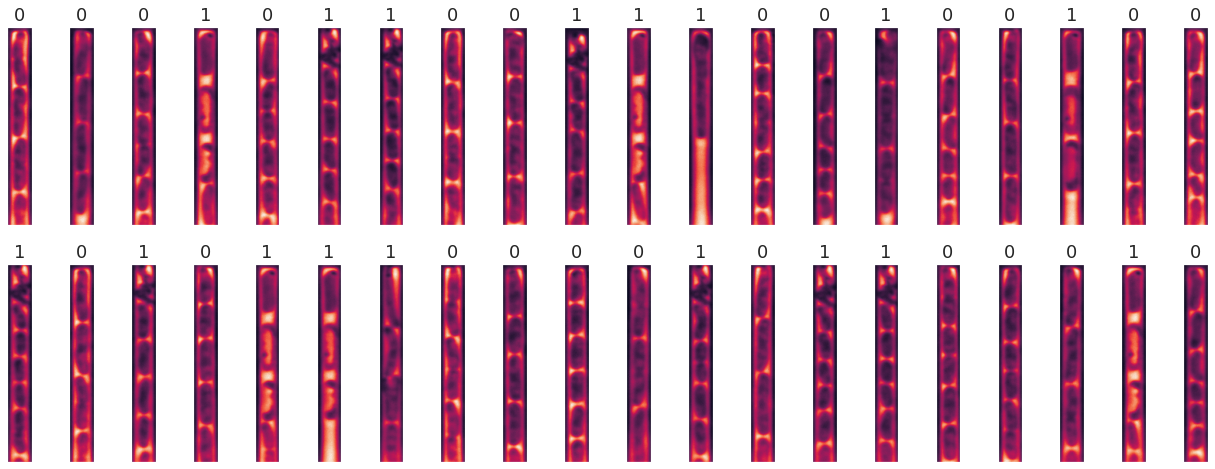

In [6]:
# check if the labels in x_test correspond to the images

def plot_images(bx, labs, n_ims=20):
    fig, axes = plt.subplots(2, (n_ims + 1) // 2, figsize=(22, 8), sharex="all", sharey="all")

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(bx[i].squeeze(-1))
        ax.set_title(int(labs[i]))
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

bx, (by, labsy) = x_test[0]
plot_images(by, labsy, n_ims=40)

## Build model

In [7]:
from uad.models.architecture import get_unet_vae, get_ruff_vae
from uad.models.variational_autoencoder import Sampling
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

from uad.models.self_attention import SelfAttention

n_filters = 64
n_contractions = 4
input_dims = (256, 32, 1)
latent_depth = n_filters * int(2**n_contractions)
latent_dims = (int(256 / (2**n_contractions)), int(32 / (2**n_contractions)), latent_depth)
batchnorm, dropout, spatial_dropout = False, 0, 0
activation_function = "linear"
k_size = (3, 1)

encoder, decoder = get_unet_vae(n_filters=n_filters, n_contractions=n_contractions,
                                input_dims=input_dims, k_size=k_size, batchnorm=batchnorm,
                                dropout=dropout, spatial_dropout=spatial_dropout,
                                activation_function=activation_function, latent_depth=latent_depth)

# def get_ruff_vae(input_dims=(32, 32, 3), n_filters=(32, 64, 128), k_size=(5, 5), LAMBDA=1e-6,
#                  spatial_dropout=0.2, dropout=0, batchnorm=False):
#     """
#     LeNet-type architecture descirbed by Ruff et al. in their publication
#     :param input_dims:
#     :param n_filters:
#     :param dense_sizes:
#     :param k_size:
#     :param LAMBDA:
#     :param spatial_dropout:
#     :param dropout:
#     :param batchnorm:
#     :return:
#     """
#     inputs = tf.keras.Input(shape=input_dims)

#     # contraction
#     n_contractions = len(n_filters)
#     for i in range(n_contractions):
#         if i == 0:
#             x = layers.Conv2D(filters=n_filters[i], kernel_size=k_size, strides=(1, 1), kernel_regularizer=l2(LAMBDA),
#                               padding="same", name=f"conv_1")(inputs)
#         else:
#             x = layers.Conv2D(filters=n_filters[i], kernel_size=k_size, strides=(1, 1), kernel_regularizer=l2(LAMBDA),
#                               padding="same")(x)
#         if spatial_dropout != 0:
#             x = layers.SpatialDropout2D(spatial_dropout)(x)
#         if dropout != 0:
#             x = layers.Dropout(dropout)(x)
#         if batchnorm:
#             x = layers.BatchNormalization()(x)
#         x = layers.LeakyReLU(alpha=0.1)(x)
#         x = layers.MaxPooling2D((2, 2))(x)

#     latent_depth = n_filters[-1]
#     latent_dims = (int(input_dims[0] / (2 ** n_contractions)), int(input_dims[1] / (2 ** n_contractions)), latent_depth)

#     print(latent_dims)

#     s = SelfAttention(latent_depth, (latent_dims[0], latent_dims[1]), positional_encoding=True)(x)[0]
#     c = layers.Concatenate(axis=-1)([x, s])  # good axis ?

#     z_mean = layers.Conv2D(latent_depth, 1, strides=1, name="z_mean")(c)
#     z_log_var = layers.Conv2D(latent_depth, 1, strides=1, name="z_log_var")(c)
#     z = Sampling()((z_mean, z_log_var))

#     encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")

#     # expansion
#     latent_inputs = tf.keras.Input(shape=latent_dims)

#     for i in range(n_contractions - 1, -1, -1):
#         if i == n_contractions - 1:
#             x = layers.Conv2DTranspose(n_filters[i], kernel_size=k_size, strides=(2, 2))(latent_inputs)
#         else:
#             x = layers.Conv2DTranspose(n_filters[i], kernel_size=k_size, strides=(2, 2))(x)
#         x = layers.Conv2D(filters=n_filters[i], kernel_size=k_size, strides=(1, 1), kernel_regularizer=l2(LAMBDA),
#                           padding="same")(x)
#         x = layers.LeakyReLU(alpha=0.1)(x)
#         if spatial_dropout != 0:
#             x = layers.SpatialDropout2D(spatial_dropout)(x)
#         if dropout != 0:
#             x = layers.Dropout(dropout)(x)
#         if batchnorm:
#             x = layers.BatchNormalization()(x)

#     x = layers.Conv2D(filters=input_dims[-1], kernel_size=k_size, strides=(1, 1), kernel_regularizer=l2(LAMBDA),
#                       padding="same")(x)

#     x = tf.keras.layers.Cropping2D(cropping=((4, 3), (0, 0)))(x)

#     decoder = Model(latent_inputs, x, name="encoder")

#     return encoder, decoder


# encoder, decoder = get_ruff_vae(input_dims=input_dims, n_filters=(128, 256, 512),
#                                 k_size=(3, 1), LAMBDA=0, dropout=0.2)

print(encoder.summary(), decoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 256, 32, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 32, 64)  256         encoder_inputs[0][0]             
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 32, 64)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 32, 64)  12352       activation[0][0]                 
____________________________________________________________________________________________

In [8]:
from uad.models.variational_autoencoder import VAE

vae = VAE(encoder, decoder, dims=(256, 32, 1), reconstruction_loss="mse", BETA=1)

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=5e-3,
#     decay_steps=10000,
#     decay_rate=0.9)

vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

In [9]:
epochs = 100
batch_size = 4

import datetime, os
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = vae.fit(x_train, validation_data=x_val, epochs=epochs, callbacks=[tensorboard_callback])

Epoch 1/100
100/100 [==============================] - 40s 405ms/step - loss: 54909150396.1287 - reconstruction_loss: 54906214242.1683 - kl_loss: 2936232.5979 - val_loss: 106564880.0000 - val_reconstruction_loss: 106554776.0000 - val_kl_loss: 10106.2422
Epoch 2/100
100/100 [==============================] - 40s 403ms/step - loss: 28972423.2079 - reconstruction_loss: 28970504.8911 - kl_loss: 1918.0845 - val_loss: 388693024.0000 - val_reconstruction_loss: 388673536.0000 - val_kl_loss: 19487.0742
Epoch 3/100
100/100 [==============================] - 40s 398ms/step - loss: 15935677.6139 - reconstruction_loss: 15934546.5272 - kl_loss: 1131.0532 - val_loss: 452796160.0000 - val_reconstruction_loss: 452759552.0000 - val_kl_loss: 36597.6602
Epoch 4/100
100/100 [==============================] - 40s 403ms/step - loss: 13798189.3663 - reconstruction_loss: 13797217.0495 - kl_loss: 972.3492 - val_loss: 2130128.5000 - val_reconstruction_loss: 2129961.0000 - val_kl_loss: 167.4093
Epoch 5/100
100/10

KeyboardInterrupt: ignored

Seems that during training, we come to a local optimum with reconstrution loss around 115 and KL around 3. This local optimum is achieved when the model only predicts red images (0 everywhere) on evaluation set. Issue with the loss? Use another loss?

Other observation: during training, the validation loss is much lower (around 40) than the training loss, even without regularisation... Explanation? Is it linked with the first issue?

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
import os
os.chdir("/content/drive/My Drive/BACMMAN_DISTNET/models/")
tf.keras.models.save_model(vae, "vae_UNet_BACT")

In [ ]:
import os
os.chdir("/content/drive/My Drive/BACMMAN_DISTNET/models/")
tf.keras.models.load_model(vae, "vae_UNet_BACT")

In [ ]:
z_means, zlv, _ = vae.encoder.predict(x_test)
predictions = vae.predict(x_test)

## Plot images and reconstructions

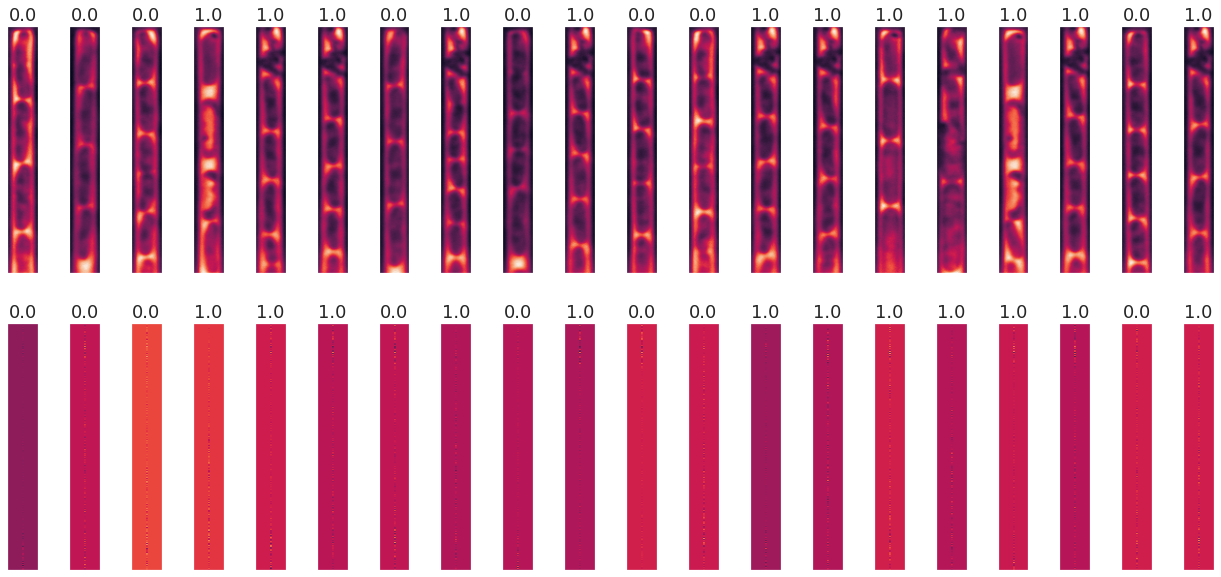

In [10]:
def plot_images_reconstructions(model, iterator, n_images=15, batch_size=4):

    fig, axes = plt.subplots(2, n_images, figsize=(22, 10), sharex="all", sharey="all")

    concerned_batches = (n_images + 1) //  batch_size
    predictions = []
    for k in range(concerned_batches):
        pred = model.predict(iterator[concerned_batches])
        predictions.append(pred)

    for i in range(n_images):
        batch = i // (batch_size)
        imx, (imy, laby) = iterator[batch]
        axes[0][i].imshow(imy[i % batch_size].squeeze(-1))
        axes[0][i].set_title(laby[i % batch_size])
        axes[1][i].imshow(predictions[batch][i % batch_size].squeeze(-1))
        axes[1][i].set_title(laby[i % batch_size])
        axes[0][i].get_xaxis().set_visible(False)
        axes[1][i].get_yaxis().set_visible(False)
        axes[0][i].get_xaxis().set_ticks([])
        axes[1][i].get_yaxis().set_ticks([])

plot_images_reconstructions(vae, x_test, n_images=20, batch_size=4)    

In [ ]:
bx, (by, lab) = x_test[0]
predictions = vae.predict(by)

In [ ]:
print(predictions[0])